# 2. Topic modelling

## Setup

In [1]:
%run __init__.py

In [2]:
import pandas as pd
import pyLDAvis
import pyLDAvis.sklearn

pyLDAvis.enable_notebook()

/home/alejandro/.envs/edma/lib/python3.7/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [3]:
from herc_common.utils import save_object

In [4]:
RANDOM_SEED=42

## Loading the dataframe

In [5]:
GIT_FILE_PATH = os.path.join(NOTEBOOK_1_RESULTS_DIR, 'git_dataframe.pkl')

git_df = pd.read_pickle(GIT_FILE_PATH)

## Preprocessing text

In [6]:
git_repositories = git_df['full_text_cleaned'].values

In [7]:
import en_core_sci_lg

from herc_common.text import TextPreprocessor


custom_stop_words = {"merge", "branch", "master", "refs", "svn",
                     "branch", "pull", "request", "fix", "ref",
                     "error", "add", "file", "bug", "class", "return",
                     "string", "test", "case", "run", "install", "object",
                     "readme"}

git_preprocessor = TextPreprocessor(en_core_sci_lg, custom_stop_words)
preprocessed_texts = git_preprocessor.fit_transform(git_repositories)

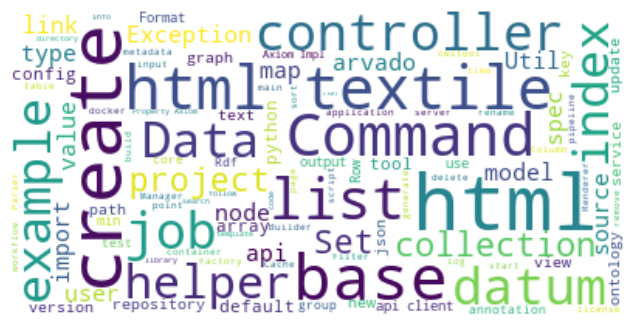

In [8]:
from herc_common.text import plot_word_cloud

complete_text = ' '.join([' '.join(token) for token in preprocessed_texts])

plot_word_cloud(complete_text)

## LDA

In [9]:
from sklearn.feature_extraction.text import CountVectorizer

def dummy(doc):
    return doc


tf_vectorizer = CountVectorizer(preprocessor=dummy, tokenizer=dummy, ngram_range=(1, 2))
dtm_tf = tf_vectorizer.fit_transform(preprocessed_texts)

In [10]:
from sklearn.decomposition import LatentDirichletAllocation

from herc_common.topic_modeling import base_scoring_function, compute_model_results


lda_scoring_func = lambda clf, X: base_scoring_function(vectorizer=tf_vectorizer,
                                        texts=preprocessed_texts, model=clf, X=X,
                                        top_n=5)


lda_results = compute_model_results(LatentDirichletAllocation, dtm_tf,
                                    lda_scoring_func, seed=RANDOM_SEED,
                                    min_topics=15, max_topics=70, max_iter=100)
lda_results

/home/alejandro/.envs/edma/lib/python3.7/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


{LatentDirichletAllocation(max_iter=100, n_components=15, random_state=42): -2.0353307354965504,
 LatentDirichletAllocation(max_iter=100, n_components=16, random_state=42): -1.4691661597758565,
 LatentDirichletAllocation(max_iter=100, n_components=17, random_state=42): -3.509017923882828,
 LatentDirichletAllocation(max_iter=100, n_components=18, random_state=42): -4.006899917718244,
 LatentDirichletAllocation(max_iter=100, n_components=19, random_state=42): -4.507544611032728,
 LatentDirichletAllocation(max_iter=100, n_components=20, random_state=42): -2.143969569161066,
 LatentDirichletAllocation(max_iter=100, n_components=21, random_state=42): -2.3141980136656866,
 LatentDirichletAllocation(max_iter=100, n_components=22, random_state=42): -3.526568181486155,
 LatentDirichletAllocation(max_iter=100, n_components=23, random_state=42): -1.4946575919540366,
 LatentDirichletAllocation(max_iter=100, n_components=24, random_state=42): -3.960210843210424,
 LatentDirichletAllocation(max_iter=

In [11]:
from herc_common.topic_modeling import get_best_model, print_results_info

print_results_info(lda_results)
best_lda_model = get_best_model(lda_results)

Best model parameters: {'batch_size': 128, 'doc_topic_prior': None, 'evaluate_every': -1, 'learning_decay': 0.7, 'learning_method': 'batch', 'learning_offset': 10.0, 'max_doc_update_iter': 100, 'max_iter': 100, 'mean_change_tol': 0.001, 'n_components': 16, 'n_jobs': None, 'perp_tol': 0.1, 'random_state': 42, 'topic_word_prior': None, 'total_samples': 1000000.0, 'verbose': 0}
Topic coherence: -1.4691661597758565


In [12]:
from herc_common.topic_modeling import print_top_words

tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(best_lda_model, tf_feature_names, 10)

Topic #0: match ontology wikidata triple entity class match ontology ontomatcher rdfs test
Topic #1: prov pass pass prov property prov property Prov influence issue license toolbox
Topic #2: unimath Disp Bicat Functor Functors Category Categories Strict Monads Pseudo
Topic #3: log jquery datum sort min Data gifs animate animate gifs Exception
Topic #4: Axiom Property Impl html Factory Data Builder Format OWLOntology controller
Topic #5: dropdown cell color format import script datum row false font
Topic #6: stability quality datum quality quality obo stability stability agro datum datum optimal metric
Topic #7: graph main build example odgi sort lirical path node Command
Topic #8: Data Learning Cheat Python Sheet Cheat Sheet Machine Learning Machine Science Data Science
Topic #9: base Command array create function Index trackhub Operation right property
Topic #10: version mpcc optimize algorithm MKL provide code Github compile coefficient
Topic #11: job tool cwltool package workflow co

In [13]:
pyLDAvis.sklearn.prepare(best_lda_model, dtm_tf, tf_vectorizer, mds='tsne')

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
4     -225.349854  113.708771       1        1  25.824156
3      -11.214129  210.724503       2        1  19.383025
9     -370.246948  298.926941       3        1  15.963754
11    -115.863266  418.656219       4        1   9.159176
14     -38.937935  -11.941959       5        1   8.962516
13    -468.892181   27.747469       6        1   4.978699
7      394.578949  -27.335003       7        1   3.678856
12     195.150314  102.077026       8        1   2.063279
8     -445.241516 -257.978210       9        1   2.044545
2      -54.327461 -242.647034      10        1   1.973038
15    -219.093063 -421.854706      11        1   1.840809
1      147.051407 -128.542709      12        1   1.387602
6     -249.556183 -122.286224      13        1   1.272989
5      295.431061 -302.292206      14        1   0.838287
10     209.292816  347.965088      15        1   0.517706
0       68.881561 -446.165314      16        1   0.111563, topic_info=               Term        Freq       Total Category  logprob  loglift
20218          html  352.000000  352.000000  Default  30.0000  30.0000
2229           Data  186.000000  186.000000  Default  29.0000  29.0000
32684       textile  114.000000  114.000000  Default  28.0000  28.0000
20371  html textile  114.000000  114.000000  Default  27.0000  27.0000
555           Axiom  172.000000  172.000000  Default  26.0000  26.0000
...             ...         ...         ...      ...      ...      ...
17446        entity    0.073646   17.562457  Topic16  -7.0168   1.3241
32536          test    0.037947   43.076871  Topic16  -7.6798  -0.2362
20887    individual    0.037944   27.264270  Topic16  -7.6799   0.2211
14663       contain    0.037942   27.299642  Topic16  -7.6800   0.2198
22599          line    0.037937   34.831519  Topic16  -7.6801  -0.0240

[1043 rows x 6 columns], token_table=       Topic      Freq           Term
term                                 
2         11  0.996254           AIDA
4         11  0.614016  AIDA sentence
29         6  1.005598    APIEndpoint
61        10  0.595705        Abelian
163       13  0.595424           Agro
...      ...       ...            ...
35145      7  0.021714       workflow
35145     11  0.021714       workflow
35323      4  0.998990            xgb
35363      6  1.005598    xmlrenderer
35399     14  0.873483   xspreadsheet

[1643 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 4, 10, 12, 15, 14, 8, 13, 9, 3, 16, 2, 7, 6, 11, 1])

In [14]:
from sklearn.pipeline import Pipeline

lda_pipeline = Pipeline([('preprocessing', git_preprocessor),
                         ('vectorizer', tf_vectorizer),
                         ('model', best_lda_model)])

lda_git_pipe_filename = "git_lda_model.pkl"
save_object(lda_pipeline, os.path.join(NOTEBOOK_2_RESULTS_DIR, lda_git_pipe_filename))

In [15]:
dtm_tf_filename = "git_dtm_tf.pkl"

save_object(dtm_tf, os.path.join(NOTEBOOK_2_RESULTS_DIR, dtm_tf_filename))

# LSA

In [16]:
from sklearn.decomposition import TruncatedSVD

lsa_scoring_func = lda_scoring_func

lsa_results = compute_model_results(TruncatedSVD, dtm_tf, lsa_scoring_func, 
                                    seed=RANDOM_SEED, min_topics=15,
                                    max_topics=70)
lsa_results

{TruncatedSVD(n_components=15, random_state=42): -2.538697241926386,
 TruncatedSVD(n_components=16, random_state=42): -2.4464084633010454,
 TruncatedSVD(n_components=17, random_state=42): -2.322888764885247,
 TruncatedSVD(n_components=18, random_state=42): -2.728629871296186,
 TruncatedSVD(n_components=19, random_state=42): -2.613936414009039,
 TruncatedSVD(n_components=20, random_state=42): -2.547129005086812,
 TruncatedSVD(n_components=21, random_state=42): -2.468249916010226,
 TruncatedSVD(n_components=22, random_state=42): -2.7139558112783124,
 TruncatedSVD(n_components=23, random_state=42): -2.641918642027921,
 TruncatedSVD(n_components=24, random_state=42): -2.769864983575026,
 TruncatedSVD(n_components=25, random_state=42): -2.6805714978607615,
 TruncatedSVD(n_components=26, random_state=42): -2.605038124390779,
 TruncatedSVD(n_components=27, random_state=42): -2.537579188415475,
 TruncatedSVD(n_components=28, random_state=42): -2.4717066167045627,
 TruncatedSVD(n_components=29,

In [17]:
print_results_info(lsa_results)
best_lsa_model = get_best_model(lsa_results)

Best model parameters: {'algorithm': 'randomized', 'n_components': 50, 'n_iter': 5, 'random_state': 42, 'tol': 0.0}
Topic coherence: -1.8394450470059136


In [18]:
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(best_lsa_model, tf_feature_names, 10)

Topic #0: html textile html textile job collection create controller user api container
Topic #1: Axiom Property Impl Factory Data Builder Format OWLOntology ontology Visitor
Topic #2: base Command array create core Index source map min Operation
Topic #3: job tool cwltool package workflow output CWL cwl plugin command
Topic #4: spec bill datum jquery html page gifs animate gifs animate controller
Topic #5: datum gifs animate gifs animate colorbox jquery colorbox colorbox jquery jquery Data textile
Topic #6: Data Connection Exception Handler Statement Mysql Category Regression Category Handler Result
Topic #7: log poly poly log feature season point player reduce log reduce reduce feature
Topic #8: Data Learning Cheat Python Sheet Cheat Sheet Machine Machine Learning Data Science Science
Topic #9: stability quality quality quality stability stability obo agro datum datum datum optimal metric
Topic #10: Utils Renderer Property Model spec Elda min Query icon link
Topic #11: codon find pos

In [19]:
lsa_pipeline = Pipeline([('preprocessing', git_preprocessor),
                         ('vectorizer', tf_vectorizer),
                         ('model', best_lsa_model)])

lsa_git_pipe_filename = "git_lsa_model.pkl"
save_object(lsa_pipeline, os.path.join(NOTEBOOK_2_RESULTS_DIR, lsa_git_pipe_filename))

## NMF

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(preprocessor=dummy, tokenizer=dummy, ngram_range=(1, 2))
dtm_tfidf = tfidf_vectorizer.fit_transform(preprocessed_texts)

In [21]:
from sklearn.decomposition import NMF

nmf_scoring_func = lambda clf, X: base_scoring_function(vectorizer=tfidf_vectorizer,
                                                        texts=preprocessed_texts, model=clf, X=X)

nmf_results = compute_model_results(NMF, dtm_tfidf, nmf_scoring_func, 
                                    seed=RANDOM_SEED, min_topics=5,
                                    max_topics=70, max_iter=1000)
nmf_results

{NMF(max_iter=1000, n_components=5, random_state=42): -6.305367566899842,
 NMF(max_iter=1000, n_components=6, random_state=42): -4.392080474588473,
 NMF(max_iter=1000, n_components=7, random_state=42): -4.476033295134199,
 NMF(max_iter=1000, n_components=8, random_state=42): -5.158464318577359,
 NMF(max_iter=1000, n_components=9, random_state=42): -7.087001608523955,
 NMF(max_iter=1000, n_components=10, random_state=42): -6.930563942915202,
 NMF(max_iter=1000, n_components=11, random_state=42): -6.482399025477441,
 NMF(max_iter=1000, n_components=12, random_state=42): -7.363493347355097,
 NMF(max_iter=1000, n_components=13, random_state=42): -7.154964581114671,
 NMF(max_iter=1000, n_components=14, random_state=42): -7.453151927362924,
 NMF(max_iter=1000, n_components=15, random_state=42): -7.17684389456418,
 NMF(max_iter=1000, n_components=16, random_state=42): -7.248868850643278,
 NMF(max_iter=1000, n_components=17, random_state=42): -6.595008210503815,
 NMF(max_iter=1000, n_component

In [22]:
print_results_info(nmf_results)
best_nmf_model = get_best_model(nmf_results)

Best model parameters: {'alpha': 0.0, 'beta_loss': 'frobenius', 'init': None, 'l1_ratio': 0.0, 'max_iter': 1000, 'n_components': 51, 'random_state': 42, 'shuffle': False, 'solver': 'cd', 'tol': 0.0001, 'verbose': 0}
Topic coherence: -0.5765286548401093


In [23]:
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(best_nmf_model, tfidf_feature_names, 10)

Topic #0: base Command array Index create Operation core base base sesame dialog
Topic #1: biosample BioSample BioSample RDF BioSample record record RDF BioHackathon EBI biosample xml discussion
Topic #2: Formik app eject npm example Formik React build mode Validation example open view
Topic #3: mpcc optimize MKL version Pearsons coefficient optimize version correlation coefficient Intel MKL Pearsons correlation
Topic #4: concept tbox abox subsumption format expansion check axiom consistency relationname
Topic #5: sort Heap Linked List Pointer Linked Makefile Implementing Str Algorithm Str Implementing
Topic #6: sentence Wasserstein daily latent latent space train snli valid space generation
Topic #7: jetty Kefed powerloom system small ball tab pin Template Data
Topic #8: unimath Disp Bicat Functor Functors Category Categories Pseudo Monads Strict
Topic #9: classifier xgb music checkpoint vgg curve xgb classifier feature Genre Classification Music Genre
Topic #10: Calculate Meme Terms 

In [24]:
from sklearn.pipeline import Pipeline

nmf_pipeline = Pipeline([('preprocessing', git_preprocessor),
                         ('vectorizer', tfidf_vectorizer),
                         ('model', best_nmf_model)])

nmf_git_pipe_filename = "git_nmf_model.pkl"
save_object(nmf_pipeline, os.path.join(NOTEBOOK_2_RESULTS_DIR, nmf_git_pipe_filename))

In [25]:
dtm_tfidf_filename = "git_dtm_tfidf.pkl"

save_object(dtm_tf, os.path.join(NOTEBOOK_2_RESULTS_DIR, dtm_tfidf_filename))